# **Unsupervised - SetNo2**

Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Set the working Directory

In [2]:
import os
working_directory = "/content/drive/MyDrive/BearingAnomalyProject"
os.chdir(working_directory)


**Set No. 3**

| Index                    | Description                                                                             |
|--------------------------|-----------------------------------------------------------------------------------------|
| Recording Duration:      | March 4, 2004 09:27:46 to April 4, 2004 19:01:57                                        |
| No. of Files:            | 4,448                                                                                   |
| No. of Channels:         | 4                                                                                       |
| Channel Arrangement:     | Bearing 1 – Ch 1; Bearing2 – Ch 2; Bearing3 – Ch3; Bearing 4 – Ch 4.                    |
| File Recording Interval: | Every 10 minutes                                                                        |
| File Format:             | ASCII                                                                                   |
| Description:             | At the end of the test-to-failure experiment, outer race failure occurred in bearing 3. |

Import Required Modules

In [69]:
import os
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
import warnings

warnings.filterwarnings("ignore")
sns.set(color_codes=True)
%matplotlib inline

Load Data File for Test 3, Merged

In [70]:
merged_data = pd.read_csv('ProcessedData/MergedData/DatasetBearingTest_3.csv')
merged_data.rename(columns={'Unnamed: 0':'time'}, inplace=True)
merged_data.time = pd.to_datetime(merged_data['time'], format='%Y-%m-%d %H:%M:%S')
merged_data.index=merged_data['time']
merged_data = merged_data.sort_index()
merged_data.drop(columns=['time'], inplace=True)
merged_data

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
time,,,,
2004-03-04 09:27:46,0.061630,0.075278,0.051991,0.043475
2004-03-04 09:32:46,0.060774,0.072206,0.052239,0.042039
2004-03-04 09:42:46,0.062195,0.072886,0.054809,0.041360
2004-03-04 09:52:46,0.062994,0.073433,0.054261,0.043126
2004-03-04 10:02:46,0.061945,0.073006,0.053237,0.042617
...,...,...,...,...
2004-04-18 02:02:55,0.122483,0.188266,0.342773,0.195169
2004-04-18 02:12:55,0.110250,0.166027,0.331777,0.205829
2004-04-18 02:22:55,0.115789,0.201599,0.404317,0.222174


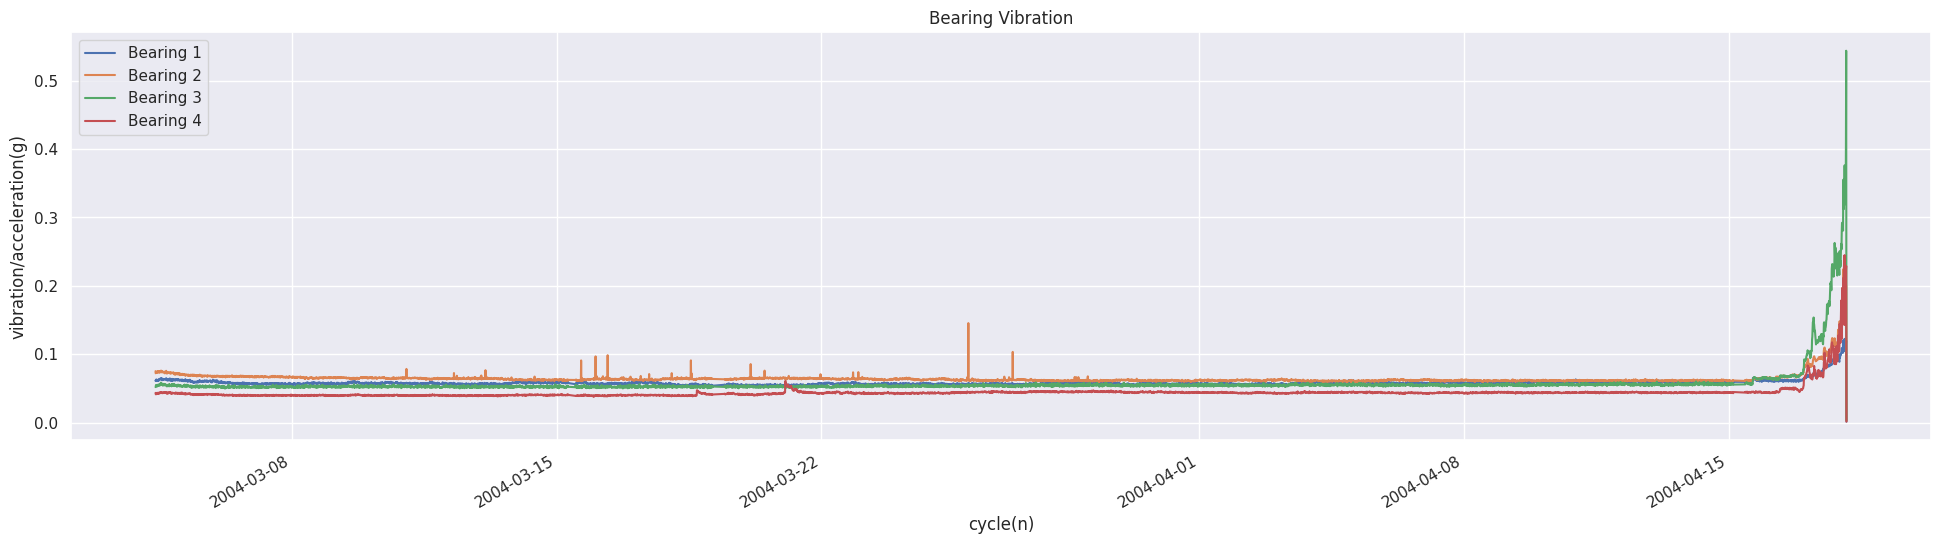

In [71]:
ax = merged_data.plot(figsize = (24,6), title= "Bearing Vibration" , legend = True)
ax.set(xlabel="cycle(n)", ylabel="vibration/acceleration(g)")
plt.show()

Split Data into Train and Test

In [72]:
split_index = int(0.7 * len(merged_data))

In [73]:
train_data = merged_data.iloc[:split_index]
test_data = merged_data.iloc[split_index:]

Normalize Data

In [74]:
scaler = preprocessing.MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(train_data), columns=train_data.columns, index=train_data.index)
X_test = pd.DataFrame(scaler.transform(test_data), columns=test_data.columns, index=test_data.index)

Isolation Forest

In [75]:
iso_forest = IsolationForest(n_estimators=1000, contamination='auto', random_state=42)
iso_forest.fit(X_train)

IsolationForest(n_estimators=1000, random_state=42)

Get anomaly scores and predictions for the train and test data

In [76]:
# Get anomaly scores and predictions for the train and test data
train_scores = iso_forest.decision_function(X_train)
train_anomalies = iso_forest.predict(X_train)
test_scores = iso_forest.decision_function(X_test)
test_anomalies = iso_forest.predict(X_test)

In [77]:
iso_forest_results = pd.DataFrame(index=X_train.index.append(X_test.index))
iso_forest_results['Score'] = np.concatenate([train_scores, test_scores])
iso_forest_results['Anomaly'] = np.concatenate([train_anomalies, test_anomalies])

In [78]:
iso_forest_results['Anomaly'] = iso_forest_results['Anomaly'] == -1

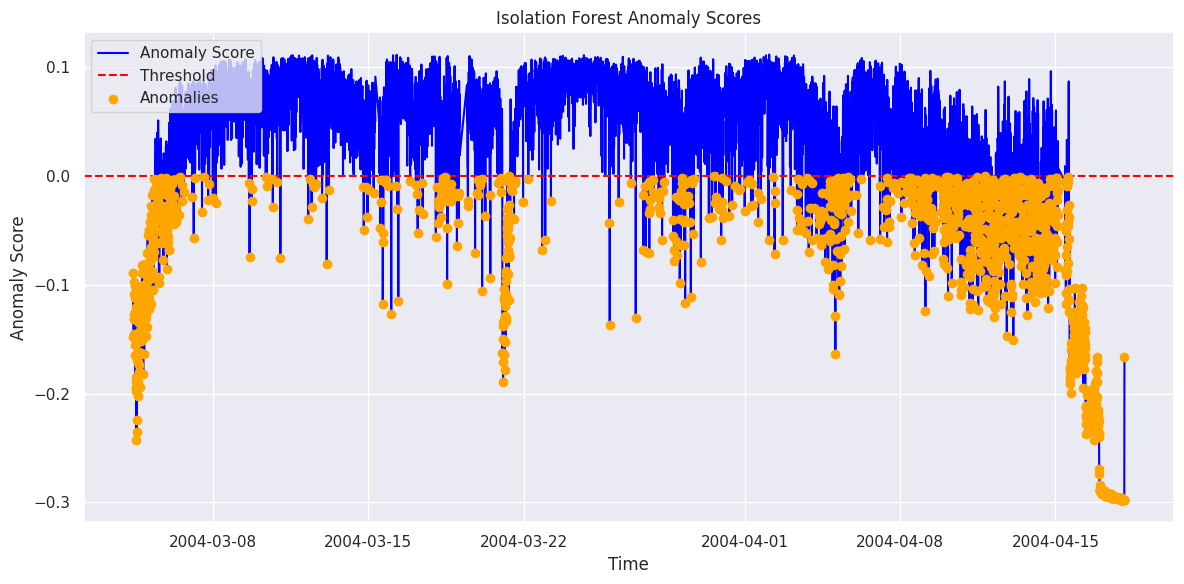

In [79]:
plt.figure(figsize=(12,6))
plt.plot(iso_forest_results.index, iso_forest_results['Score'], label='Anomaly Score', color='blue')
plt.axhline(y=0, color='red', linestyle='--', label='Threshold')
plt.scatter(iso_forest_results[iso_forest_results['Anomaly']].index,
            iso_forest_results[iso_forest_results['Anomaly']]['Score'],
            color='orange', label='Anomalies', zorder=5)
plt.title('Isolation Forest Anomaly Scores')
plt.xlabel('Time')
plt.ylabel('Anomaly Score')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

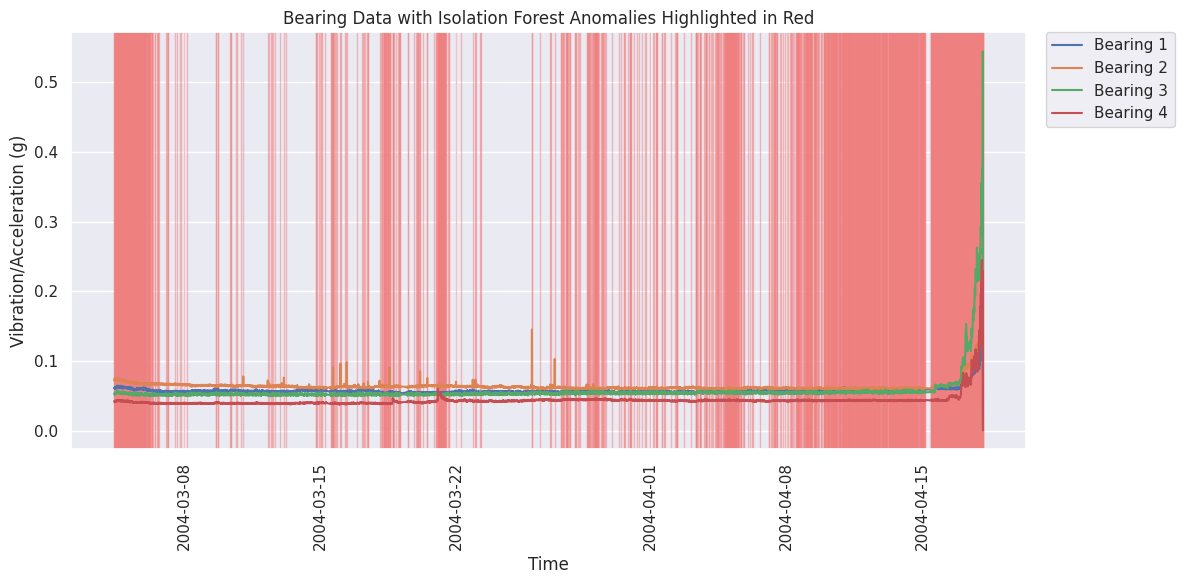

In [80]:
merged_data['Anomaly_ISO'] = iso_forest_results['Anomaly']

plt.figure(figsize=(12, 6))

for col in merged_data.columns[:-1]:
    plt.plot(merged_data.index, merged_data[col], label=col)

for i in range(len(merged_data) - 1):
    if merged_data['Anomaly_ISO'].iloc[i]:
        plt.axvspan(merged_data.index[i], merged_data.index[i + 1], color='lightcoral', alpha=0.5)

plt.title("Bearing Data with Isolation Forest Anomalies Highlighted in Red")
plt.xlabel("Time")
plt.ylabel("Vibration/Acceleration (g)")
plt.xticks(rotation=90)
plt.legend(loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0.)
plt.tight_layout()
plt.show()

It is Detecting TOO uch ANOMALIES, So, we will move to Experimenting further.

In [81]:
#set contamination to a lower value, e.g., 0.01 (1% of the data)
iso_forest = IsolationForest(n_estimators=200, contamination=0.009, random_state=42)
iso_forest.fit(X_train)

train_scores = iso_forest.decision_function(X_train)
train_anomalies = iso_forest.predict(X_train)
test_scores = iso_forest.decision_function(X_test)
test_anomalies = iso_forest.predict(X_test)

iso_forest_results = pd.DataFrame(index=X_train.index.append(X_test.index))
iso_forest_results['Score'] = np.concatenate([train_scores, test_scores])
iso_forest_results['Anomaly'] = np.concatenate([train_anomalies, test_anomalies])
iso_forest_results['Anomaly'] = iso_forest_results['Anomaly'] == -1

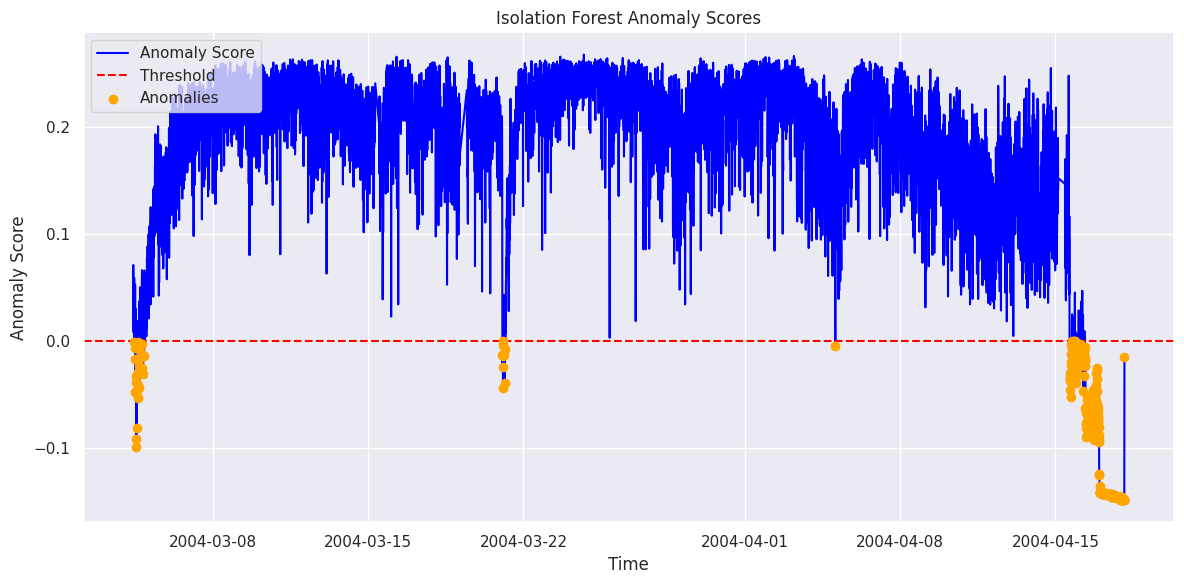

In [82]:
plt.figure(figsize=(12,6))
plt.plot(iso_forest_results.index, iso_forest_results['Score'], label='Anomaly Score', color='blue')
plt.axhline(y=0, color='red', linestyle='--', label='Threshold')
plt.scatter(iso_forest_results[iso_forest_results['Anomaly']].index,
            iso_forest_results[iso_forest_results['Anomaly']]['Score'],
            color='orange', label='Anomalies', zorder=5)
plt.title('Isolation Forest Anomaly Scores')
plt.xlabel('Time')
plt.ylabel('Anomaly Score')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

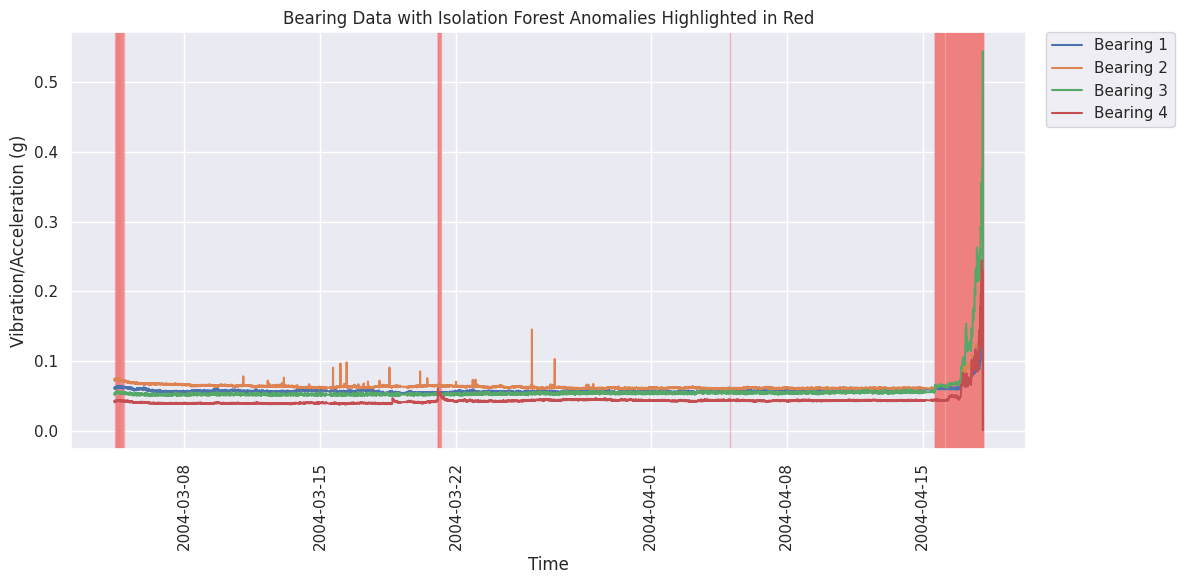

In [83]:
merged_data['Anomaly_ISO'] = iso_forest_results['Anomaly']

plt.figure(figsize=(12, 6))

for col in merged_data.columns[:-1]:
    plt.plot(merged_data.index, merged_data[col], label=col)

for i in range(len(merged_data) - 1):
    if merged_data['Anomaly_ISO'].iloc[i]:
        plt.axvspan(merged_data.index[i], merged_data.index[i + 1], color='lightcoral', alpha=0.5)

plt.title("Bearing Data with Isolation Forest Anomalies Highlighted in Red")
plt.xlabel("Time")
plt.ylabel("Vibration/Acceleration (g)")
plt.xticks(rotation=90)
plt.legend(loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0.)
plt.tight_layout()
plt.show()

Lets test with a number of contamination values

In [84]:
contamination_values = [0.005, 0.01, 0.02, 0.05]

for contamination in contamination_values:
    iso_forest = IsolationForest(n_estimators=100, contamination=contamination, random_state=42)
    iso_forest.fit(X_train)
    total_anomalies = sum(iso_forest.predict(X_test) == -1)
    print(f"Contamination: {contamination}, Total Anomalies Detected: {total_anomalies}")

Contamination: 0.005, Total Anomalies Detected: 299
Contamination: 0.01, Total Anomalies Detected: 328
Contamination: 0.02, Total Anomalies Detected: 359
Contamination: 0.05, Total Anomalies Detected: 528


Adjust n_estimators and max_samples

In [85]:
iso_forest = IsolationForest(
    n_estimators=200,
    max_samples='auto',
    random_state=42
)
iso_forest.fit(X_train)

IsolationForest(n_estimators=200, random_state=42)

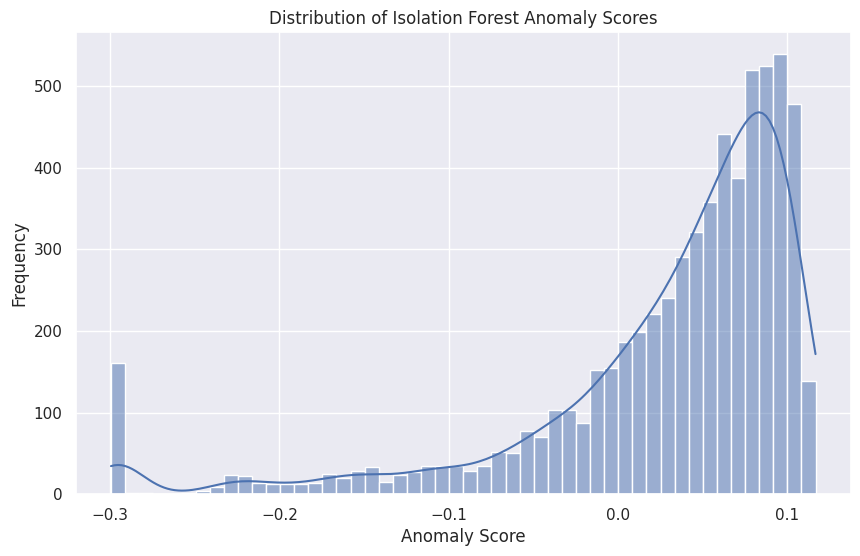

In [86]:
#calculate anomaly scores
scores = iso_forest.decision_function(pd.concat([X_train, X_test]))

#plot the distribution of scores
plt.figure(figsize=(10,6))
sns.histplot(scores, bins=50, kde=True)
plt.title('Distribution of Isolation Forest Anomaly Scores')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.show()

In [87]:
threshold = np.percentile(scores, 20)
print(f"Custom Threshold: {threshold}")

Custom Threshold: -0.010999142671590675


In [88]:
iso_forest_results['Anomaly_Custom'] = iso_forest_results['Score'] < threshold

Plotting with Adjusted Anomalies

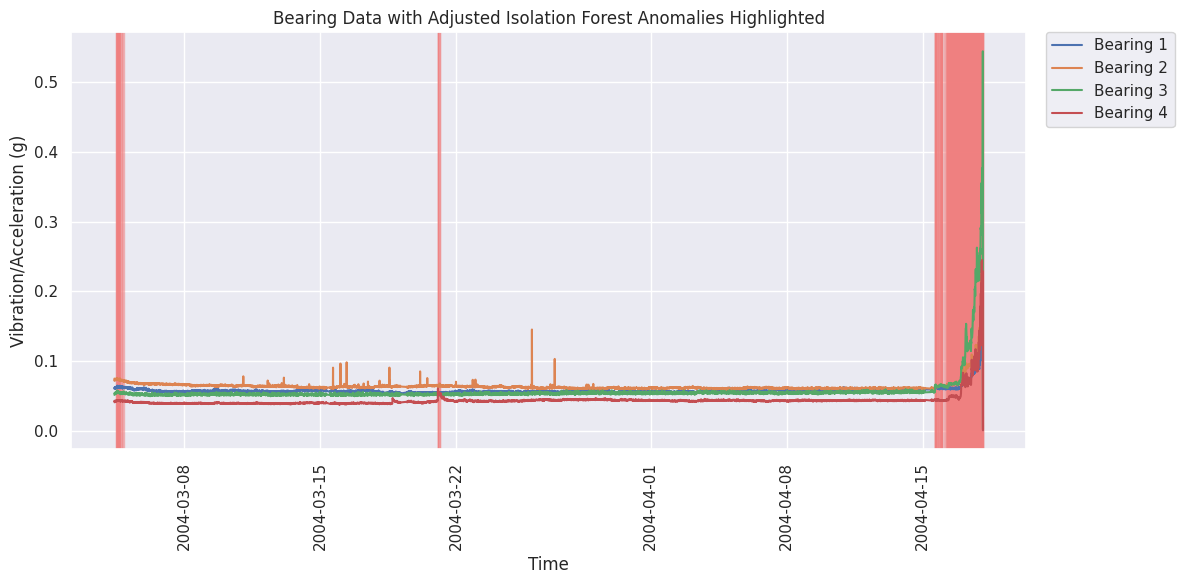

In [89]:
merged_data['Anomaly_ISO'] = iso_forest_results['Anomaly_Custom'].values

plt.figure(figsize=(12, 6))

for col in merged_data.columns[:-1]:
    plt.plot(merged_data.index, merged_data[col], label=col)

for i in range(len(merged_data) - 1):
    if merged_data['Anomaly_ISO'].iloc[i]:
        plt.axvspan(merged_data.index[i], merged_data.index[i + 1], color='lightcoral', alpha=0.5)

plt.title("Bearing Data with Adjusted Isolation Forest Anomalies Highlighted")
plt.xlabel("Time")
plt.ylabel("Vibration/Acceleration (g)")
plt.xticks(rotation=90)
plt.legend(loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0.)
plt.tight_layout()
plt.show()

In [90]:
merged_data

,Bearing 1,Bearing 2,Bearing 3,Bearing 4,Anomaly_ISO
time,,,,,
2004-03-04 09:27:46,0.061630,0.075278,0.051991,0.043475,False
2004-03-04 09:32:46,0.060774,0.072206,0.052239,0.042039,False
2004-03-04 09:42:46,0.062195,0.072886,0.054809,0.041360,False
2004-03-04 09:52:46,0.062994,0.073433,0.054261,0.043126,False
2004-03-04 10:02:46,0.061945,0.073006,0.053237,0.042617,False
...,...,...,...,...,...
2004-04-18 02:02:55,0.122483,0.188266,0.342773,0.195169,True
2004-04-18 02:12:55,0.110250,0.166027,0.331777,0.205829,True
2004-04-18 02:22:55,0.115789,0.201599,0.404317,0.222174,True


This is better and has identified the anomalies, better.

# **One-Class SVM**

In [91]:
ocsvm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.05)
ocsvm.fit(X_train)

OneClassSVM(gamma='auto', nu=0.05)

In [92]:
train_scores = ocsvm.decision_function(X_train)
train_anomalies = ocsvm.predict(X_train)
test_scores = ocsvm.decision_function(X_test)
test_anomalies = ocsvm.predict(X_test)

In [93]:
ocsvm_results = pd.DataFrame(index=X_train.index.append(X_test.index))
ocsvm_results['Score'] = np.concatenate([train_scores, test_scores])
ocsvm_results['Anomaly'] = np.concatenate([train_anomalies, test_anomalies])

#anomalies are marked as -1, normal as 1
ocsvm_results['Anomaly'] = ocsvm_results['Anomaly'] == -1

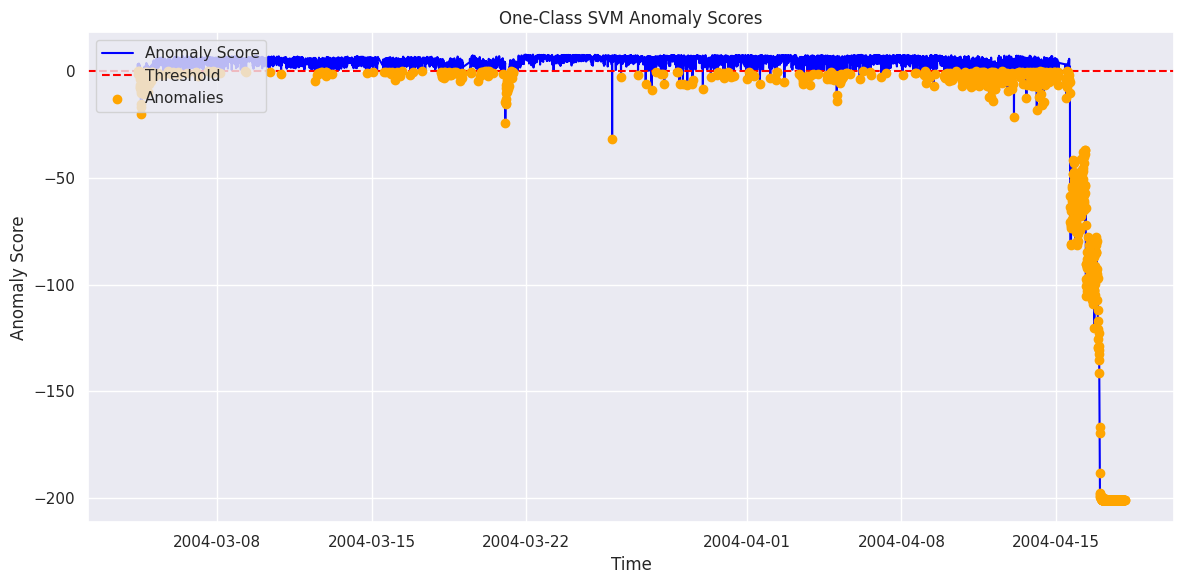

In [94]:
plt.figure(figsize=(12,6))
plt.plot(ocsvm_results.index, ocsvm_results['Score'], label='Anomaly Score', color='blue')
plt.axhline(y=0, color='red', linestyle='--', label='Threshold')
plt.scatter(ocsvm_results[ocsvm_results['Anomaly']].index,
            ocsvm_results[ocsvm_results['Anomaly']]['Score'],
            color='orange', label='Anomalies', zorder=5)
plt.title('One-Class SVM Anomaly Scores')
plt.xlabel('Time')
plt.ylabel('Anomaly Score')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

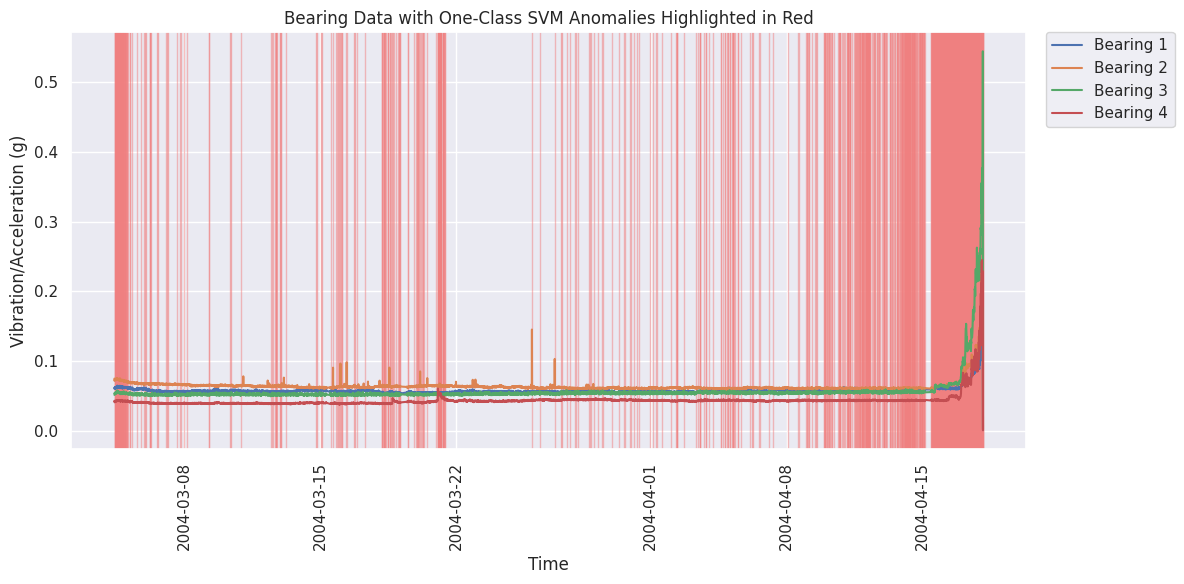

In [95]:
merged_data['Anomaly_OCSVM'] = ocsvm_results['Anomaly']

plt.figure(figsize=(12, 6))

for col in merged_data.columns[:-2]:
    plt.plot(merged_data.index, merged_data[col], label=col)

for i in range(len(merged_data) - 1):
    if merged_data['Anomaly_OCSVM'].iloc[i]:
        plt.axvspan(merged_data.index[i], merged_data.index[i + 1], color='lightcoral', alpha=0.5)

plt.title("Bearing Data with One-Class SVM Anomalies Highlighted in Red")
plt.xlabel("Time")
plt.ylabel("Vibration/Acceleration (g)")
plt.xticks(rotation=90)
plt.legend(loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0.)
plt.tight_layout()
plt.show()

this is getting a whole lot of anoalies, so it needs to be adjusted as well.

Adjust the nu Parameter

In [96]:
ocsvm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.005)  #try nu = 0.005 or even lower
ocsvm.fit(X_train)

train_scores = ocsvm.decision_function(X_train)
train_anomalies = ocsvm.predict(X_train)
test_scores = ocsvm.decision_function(X_test)
test_anomalies = ocsvm.predict(X_test)

combined_index = X_train.index.append(X_test.index)
ocsvm_results = pd.DataFrame(index=combined_index)
ocsvm_results['Score'] = np.concatenate([train_scores, test_scores])
ocsvm_results['Anomaly'] = np.concatenate([train_anomalies, test_anomalies])

# Convert predictions: anomalies are marked as -1
ocsvm_results['Anomaly'] = ocsvm_results['Anomaly'] == -1

ocsvm_results['Score'] = np.concatenate([train_scores, test_scores])
ocsvm_results['Anomaly'] = np.concatenate([train_anomalies, test_anomalies])
ocsvm_results['Anomaly'] = ocsvm_results['Anomaly'] == -1

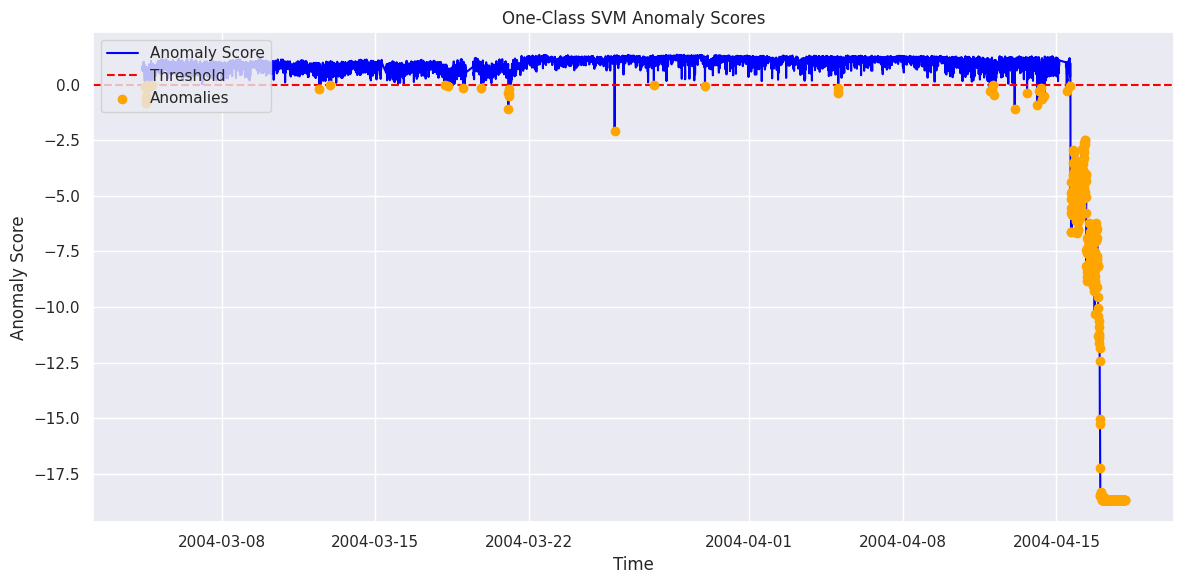

In [97]:
plt.figure(figsize=(12,6))
plt.plot(ocsvm_results.index, ocsvm_results['Score'], label='Anomaly Score', color='blue')
plt.axhline(y=0, color='red', linestyle='--', label='Threshold')
plt.scatter(ocsvm_results[ocsvm_results['Anomaly']].index,
            ocsvm_results[ocsvm_results['Anomaly']]['Score'],
            color='orange', label='Anomalies', zorder=5)
plt.title('One-Class SVM Anomaly Scores')
plt.xlabel('Time')
plt.ylabel('Anomaly Score')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

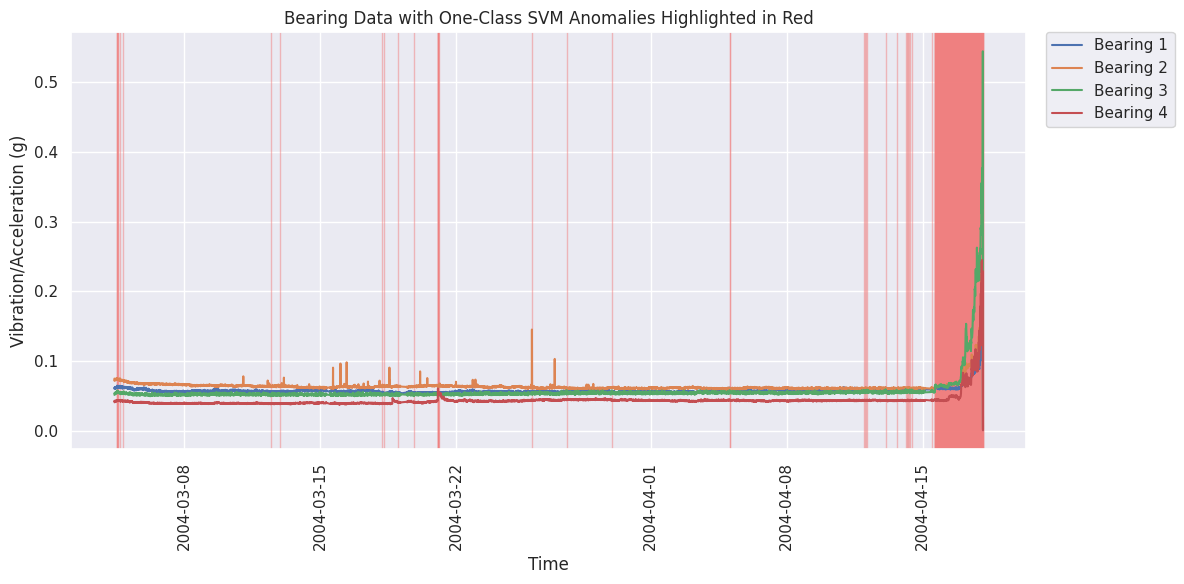

In [98]:
merged_data['Anomaly_OCSVM'] = ocsvm_results['Anomaly']

plt.figure(figsize=(12, 6))

for col in merged_data.columns[:-2]:
    plt.plot(merged_data.index, merged_data[col], label=col)

for i in range(len(merged_data) - 1):
    if merged_data['Anomaly_OCSVM'].iloc[i]:
        plt.axvspan(merged_data.index[i], merged_data.index[i + 1], color='lightcoral', alpha=0.5)

plt.title("Bearing Data with One-Class SVM Anomalies Highlighted in Red")
plt.xlabel("Time")
plt.ylabel("Vibration/Acceleration (g)")
plt.xticks(rotation=90)
plt.legend(loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0.)
plt.tight_layout()
plt.show()

Test other Gamma

In [99]:
ocsvm = OneClassSVM(kernel='rbf', gamma=0.01, nu=0.005)
ocsvm.fit(X_train)

OneClassSVM(gamma=0.01, nu=0.005)

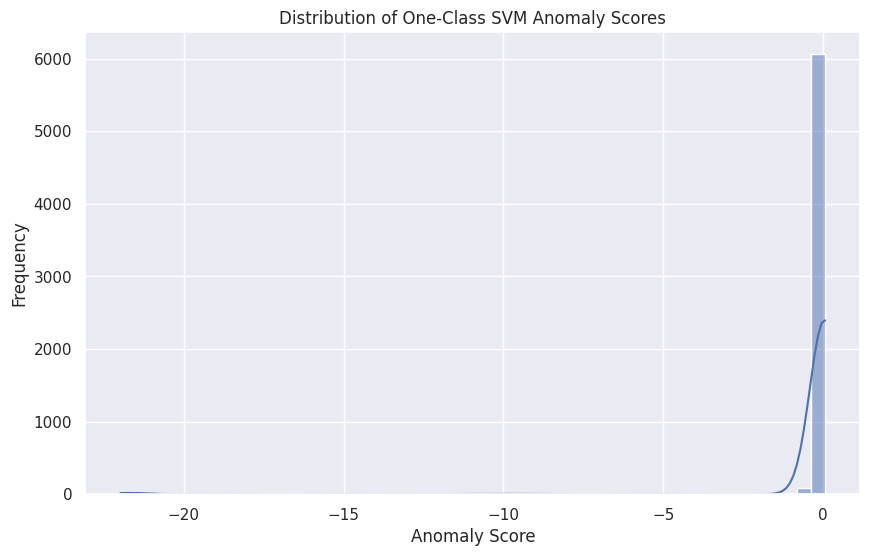

In [100]:
#calculate anomaly scores
scores = ocsvm.decision_function(pd.concat([X_train, X_test]))

#distribution of scores
plt.figure(figsize=(10,6))
sns.histplot(scores, bins=50, kde=True)
plt.title('Distribution of One-Class SVM Anomaly Scores')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.show()

In [101]:
threshold = np.percentile(scores, 25)
print(f"Custom Threshold: {threshold}")
ocsvm_results['Anomaly_Custom'] = ocsvm_results['Score'] < threshold
merged_data['Anomaly_OCSVM'] = ocsvm_results['Anomaly_Custom'].values

Custom Threshold: 0.036934843870617406


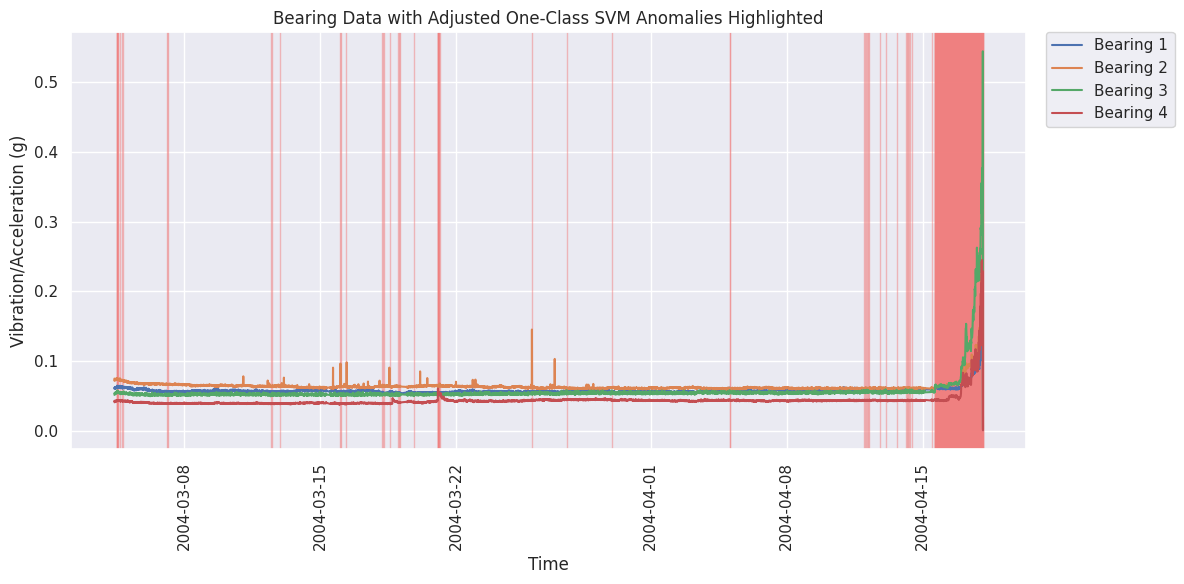

In [102]:
plt.figure(figsize=(12, 6))

for col in merged_data.columns[:-2]:
    plt.plot(merged_data.index, merged_data[col], label=col)

for i in range(len(merged_data) - 1):
    if merged_data['Anomaly_OCSVM'].iloc[i]:
        plt.axvspan(merged_data.index[i], merged_data.index[i + 1], color='lightcoral', alpha=0.5)

plt.title("Bearing Data with Adjusted One-Class SVM Anomalies Highlighted")
plt.xlabel("Time")
plt.ylabel("Vibration/Acceleration (g)")
plt.xticks(rotation=90)
plt.legend(loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0.)
plt.tight_layout()
plt.show()

this look better.

# **Local Outlier Factor (LOF)**

In [103]:
lof = LocalOutlierFactor(n_neighbors=20, contamination='auto', novelty=True)
lof.fit(X_train)

LocalOutlierFactor(novelty=True)

In [104]:
train_scores = lof.decision_function(X_train)
train_anomalies = lof.predict(X_train)
test_scores = lof.decision_function(X_test)
test_anomalies = lof.predict(X_test)

lof_results = pd.DataFrame(index=X_train.index.append(X_test.index))
lof_results['Score'] = np.concatenate([train_scores, test_scores])
lof_results['Anomaly'] = np.concatenate([train_anomalies, test_anomalies])

In [105]:
lof_results['Anomaly'] = lof_results['Anomaly'] == -1

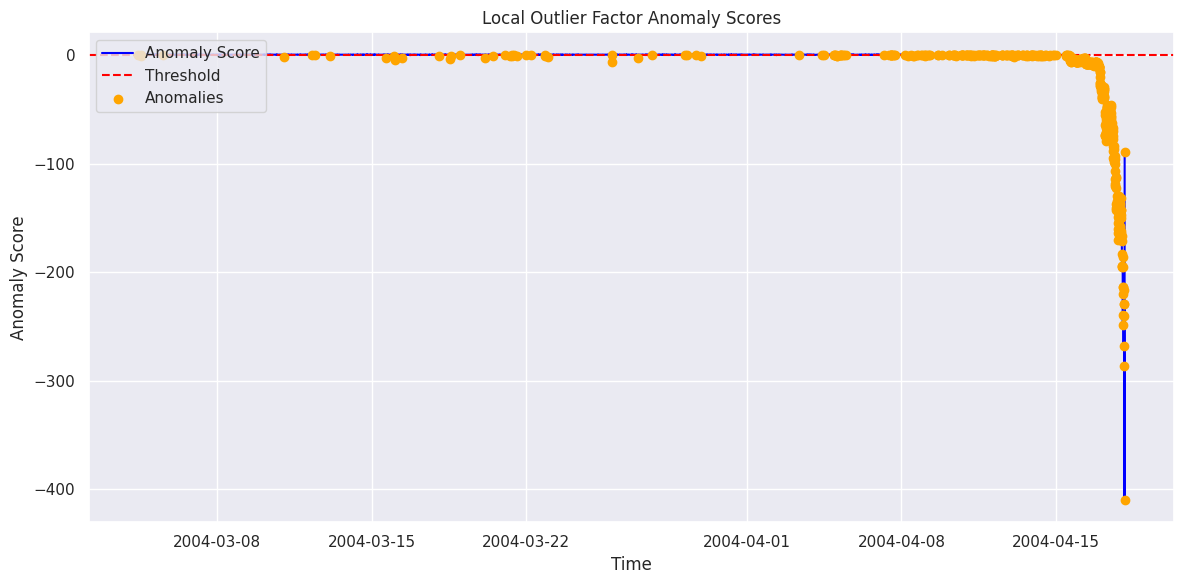

In [106]:
plt.figure(figsize=(12,6))
plt.plot(lof_results.index, lof_results['Score'], label='Anomaly Score', color='blue')
plt.axhline(y=0, color='red', linestyle='--', label='Threshold')
plt.scatter(lof_results[lof_results['Anomaly']].index,
            lof_results[lof_results['Anomaly']]['Score'],
            color='orange', label='Anomalies', zorder=5)
plt.title('Local Outlier Factor Anomaly Scores')
plt.xlabel('Time')
plt.ylabel('Anomaly Score')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

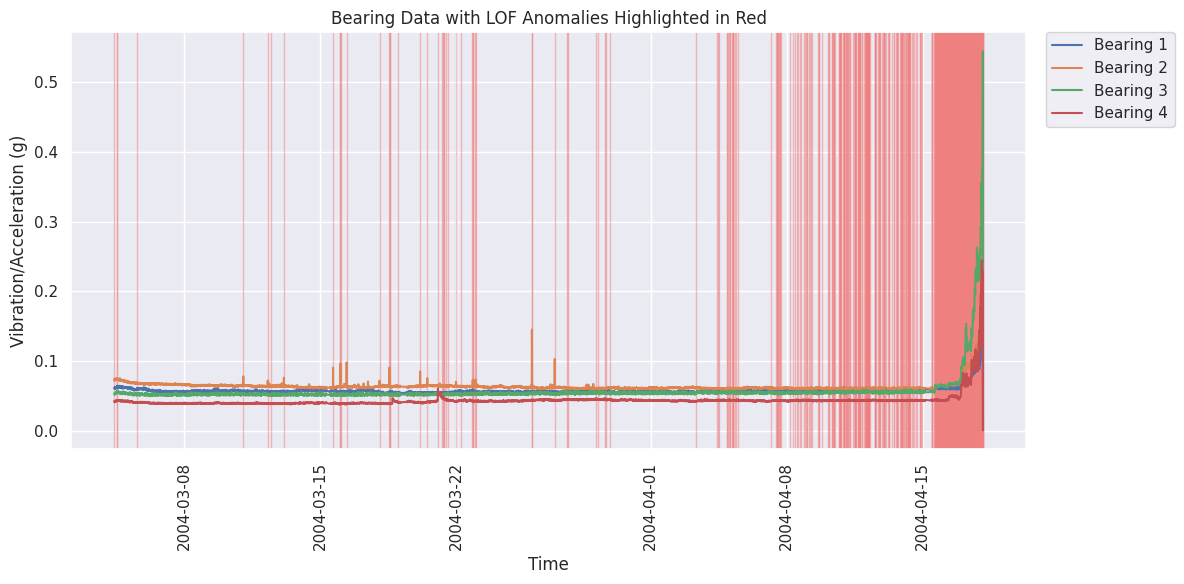

In [107]:
merged_data['Anomaly_LOF'] = lof_results['Anomaly']

plt.figure(figsize=(12, 6))

for col in merged_data.columns[:-3]:
    plt.plot(merged_data.index, merged_data[col], label=col)

for i in range(len(merged_data) - 1):
    if merged_data['Anomaly_LOF'].iloc[i]:
        plt.axvspan(merged_data.index[i], merged_data.index[i + 1], color='lightcoral', alpha=0.5)

plt.title("Bearing Data with LOF Anomalies Highlighted in Red")
plt.xlabel("Time")
plt.ylabel("Vibration/Acceleration (g)")
plt.xticks(rotation=90)
plt.legend(loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0.)
plt.tight_layout()
plt.show()

Need to Optimise it as Well. This is also detecting TOO much ANOMALIES

Adjust the contamination Parameter

In [108]:
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01, novelty=True)
lof.fit(X_train)
train_scores = lof.decision_function(X_train)
test_scores = lof.decision_function(X_test)

train_anomalies = lof.predict(X_train)
test_anomalies = lof.predict(X_test)

In [109]:
lof_results = pd.DataFrame(index=X_train.index.append(X_test.index))
lof_results['Score'] = np.concatenate([train_scores, test_scores])
lof_results['Anomaly'] = np.concatenate([train_anomalies, test_anomalies])

In [110]:
lof_results['Anomaly'] = lof_results['Anomaly'] == -1

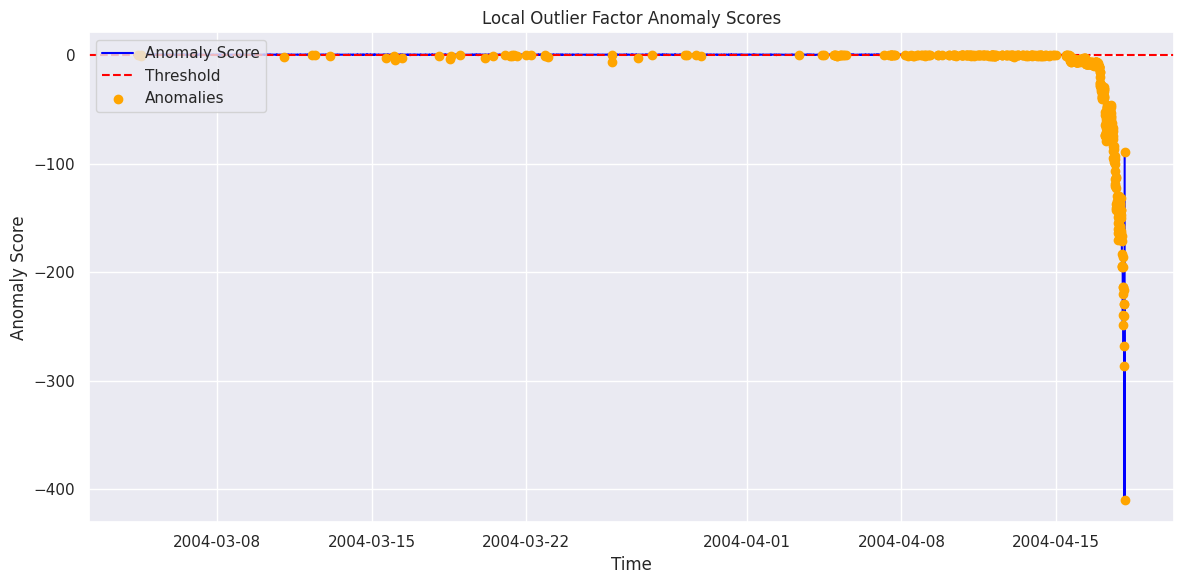

In [111]:
plt.figure(figsize=(12,6))
plt.plot(lof_results.index, lof_results['Score'], label='Anomaly Score', color='blue')
plt.axhline(y=0, color='red', linestyle='--', label='Threshold')
plt.scatter(lof_results[lof_results['Anomaly']].index,
            lof_results[lof_results['Anomaly']]['Score'],
            color='orange', label='Anomalies', zorder=5)
plt.title('Local Outlier Factor Anomaly Scores')
plt.xlabel('Time')
plt.ylabel('Anomaly Score')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

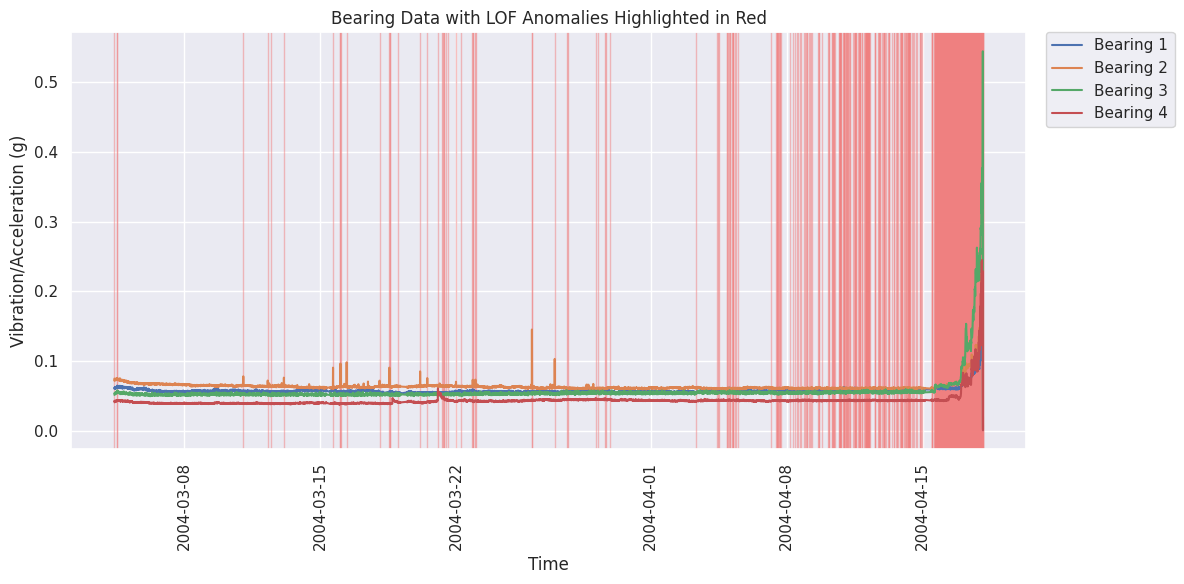

In [112]:
merged_data['Anomaly_LOF'] = lof_results['Anomaly']

plt.figure(figsize=(12, 6))

for col in merged_data.columns[:-3]:
    plt.plot(merged_data.index, merged_data[col], label=col)

for i in range(len(merged_data) - 1):
    if merged_data['Anomaly_LOF'].iloc[i]:
        plt.axvspan(merged_data.index[i], merged_data.index[i + 1], color='lightcoral', alpha=0.5)

plt.title("Bearing Data with LOF Anomalies Highlighted in Red")
plt.xlabel("Time")
plt.ylabel("Vibration/Acceleration (g)")
plt.xticks(rotation=90)
plt.legend(loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0.)
plt.tight_layout()
plt.show()

Adjust the n_neighbors Parameter

In [113]:
lof = LocalOutlierFactor(n_neighbors=35, contamination=0.01, novelty=True)
lof.fit(X_train)

LocalOutlierFactor(contamination=0.01, n_neighbors=35, novelty=True)

In [114]:
train_scores = lof.decision_function(X_train)
test_scores = lof.decision_function(X_test)

train_anomalies = lof.predict(X_train)
test_anomalies = lof.predict(X_test)

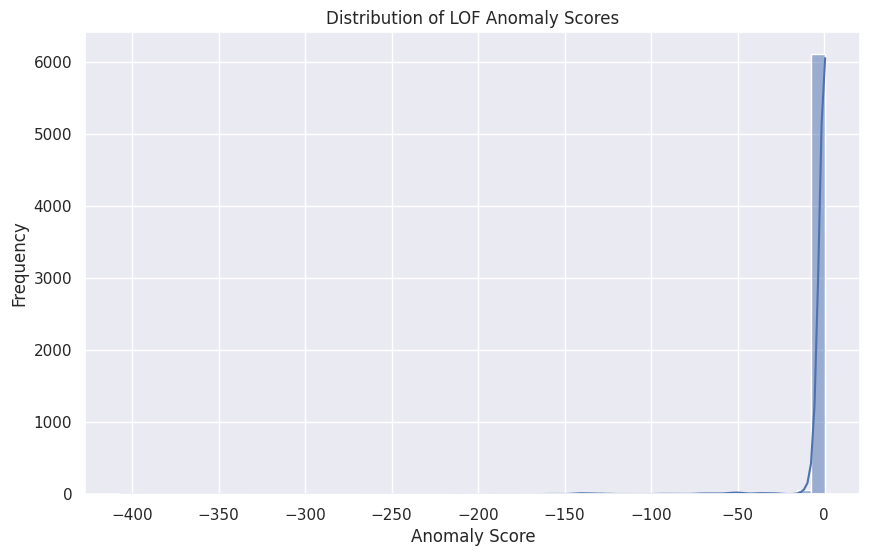

In [115]:
scores = np.concatenate([train_scores, test_scores])
plt.figure(figsize=(10,6))
sns.histplot(scores, bins=50, kde=True)
plt.title('Distribution of LOF Anomaly Scores')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.show()

In [116]:
threshold = np.percentile(scores, 25)
print(f"Custom Threshold: {threshold}")

Custom Threshold: 0.36042543931470655


In [117]:
lof_results = pd.DataFrame(index=X_train.index.append(X_test.index))
lof_results['Score'] = scores
lof_results['Anomaly'] = scores < threshold

merged_data['Anomaly_LOF'] = lof_results['Anomaly'].values

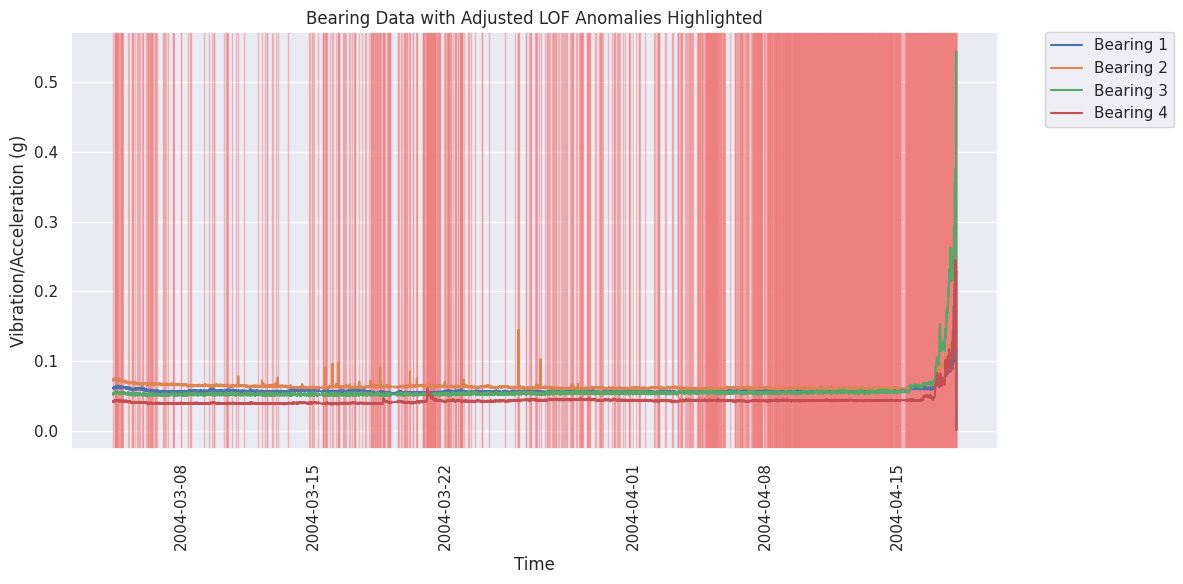

In [118]:
plt.figure(figsize=(12, 6))

for col in merged_data.columns[:-3]:
    plt.plot(merged_data.index, merged_data[col], label=col)

for i in range(len(merged_data) - 1):
    if merged_data['Anomaly_LOF'].iloc[i]:
        plt.axvspan(merged_data.index[i], merged_data.index[i + 1], color='lightcoral', alpha=0.5)

plt.title("Bearing Data with Adjusted LOF Anomalies Highlighted")
plt.xlabel("Time")
plt.ylabel("Vibration/Acceleration (g)")
plt.xticks(rotation=90)
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.tight_layout()
plt.show()


This looks better and is detecting anomalies at the end.

In [119]:
contamination_values = [0.005, 0.01, 0.02]
n_neighbors_values = [20, 35, 50]

for contamination in contamination_values:
    for n_neighbors in n_neighbors_values:
        lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination, novelty=True)
        lof.fit(X_train)
        test_anomalies = lof.predict(X_test)
        n_anomalies = np.sum(test_anomalies == -1)
        print(f"Contamination: {contamination}, n_neighbors: {n_neighbors}, Anomalies Detected: {n_anomalies}")

Contamination: 0.005, n_neighbors: 20, Anomalies Detected: 387
Contamination: 0.005, n_neighbors: 35, Anomalies Detected: 393
Contamination: 0.005, n_neighbors: 50, Anomalies Detected: 383
Contamination: 0.01, n_neighbors: 20, Anomalies Detected: 513
Contamination: 0.01, n_neighbors: 35, Anomalies Detected: 496
Contamination: 0.01, n_neighbors: 50, Anomalies Detected: 436
Contamination: 0.02, n_neighbors: 20, Anomalies Detected: 678
Contamination: 0.02, n_neighbors: 35, Anomalies Detected: 669
Contamination: 0.02, n_neighbors: 50, Anomalies Detected: 545


In [120]:
merged_data['Anomaly_ISO'] = iso_forest_results['Anomaly_Custom'].values
merged_data['Anomaly_OCSVM'] = ocsvm_results['Anomaly_Custom'].values
merged_data['Anomaly_LOF'] = lof_results['Anomaly'].values

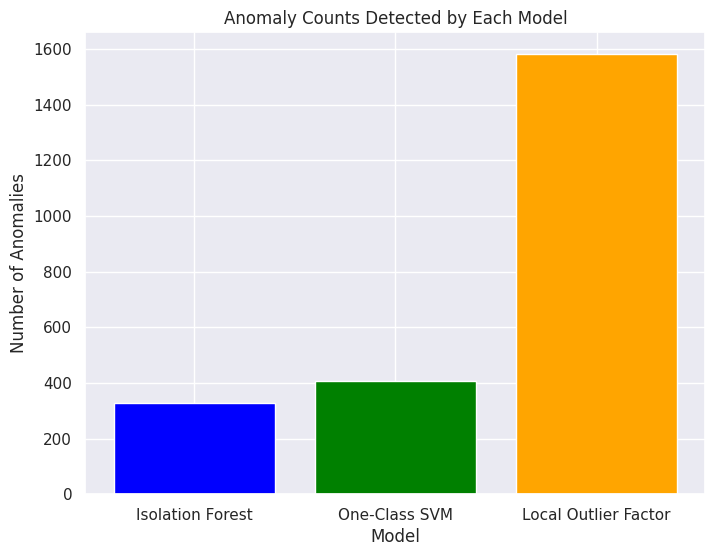

In [121]:
#Anomaly counts detected by each model (bar plot)
anomalies_iso = merged_data['Anomaly_ISO'].sum()
anomalies_ocsvm = merged_data['Anomaly_OCSVM'].sum()
anomalies_lof = merged_data['Anomaly_LOF'].sum()

plt.figure(figsize=(8, 6))
models = ['Isolation Forest', 'One-Class SVM', 'Local Outlier Factor']
anomaly_counts = [anomalies_iso, anomalies_ocsvm, anomalies_lof]
plt.bar(models, anomaly_counts, color=['blue', 'green', 'orange'])
plt.title('Anomaly Counts Detected by Each Model')
plt.xlabel('Model')
plt.ylabel('Number of Anomalies')
plt.show()

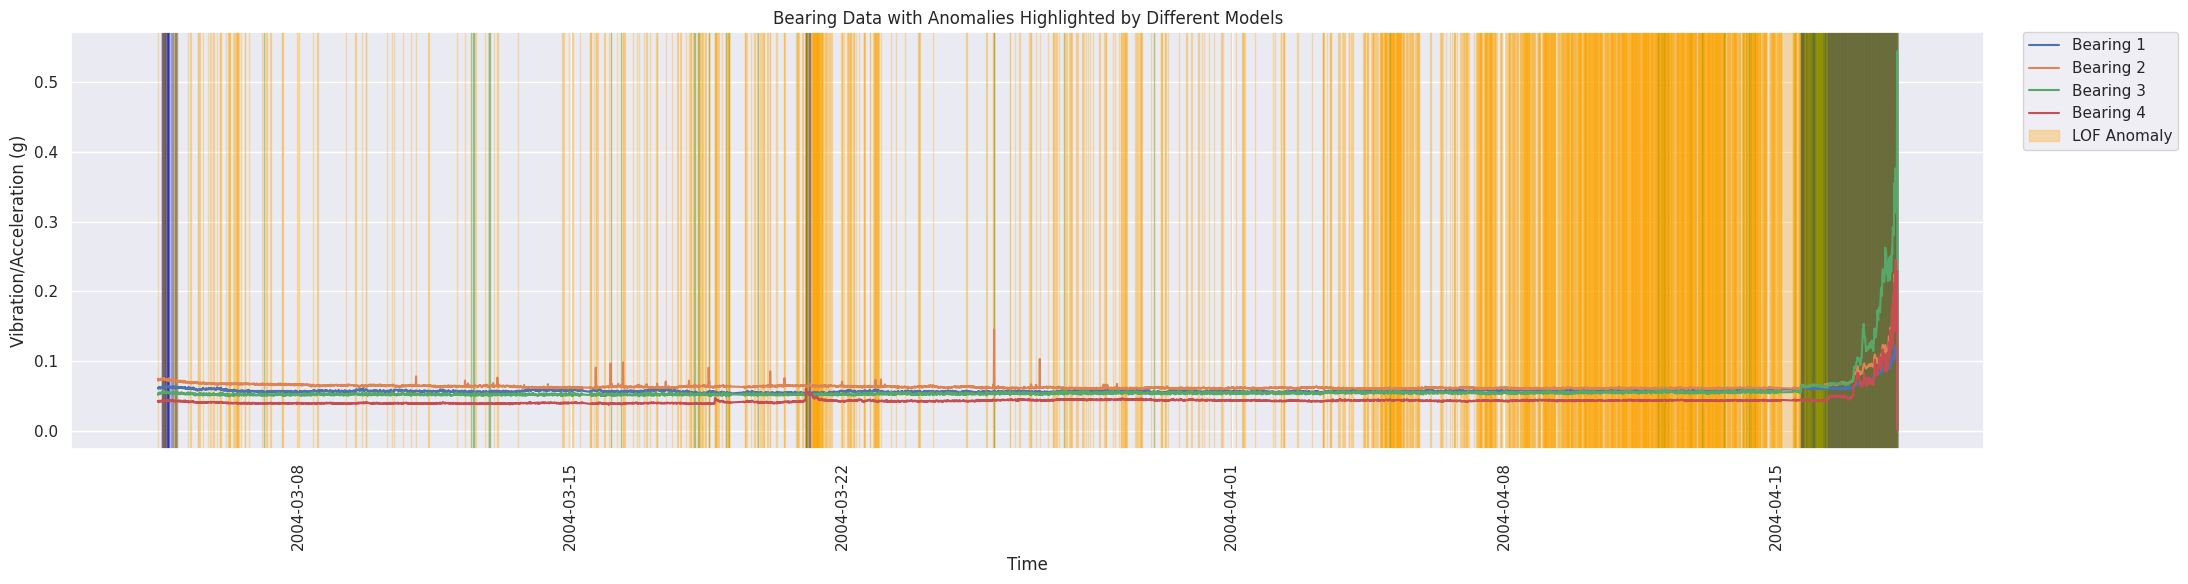

In [122]:
#Time series plot of vibration/acceleration data with anomalies highlighted

plt.figure(figsize=(22, 6))
for col in merged_data.columns[:-3]:
    plt.plot(merged_data.index, merged_data[col], label=col)

for i in range(len(merged_data) - 1):
    if merged_data['Anomaly_ISO'].iloc[i]:
        plt.axvspan(merged_data.index[i], merged_data.index[i + 1], color='blue', alpha=0.3, label="ISO Forest Anomaly" if i == 0 else "")
    if merged_data['Anomaly_OCSVM'].iloc[i]:
        plt.axvspan(merged_data.index[i], merged_data.index[i + 1], color='green', alpha=0.3, label="OCSVM Anomaly" if i == 0 else "")
    if merged_data['Anomaly_LOF'].iloc[i]:
        plt.axvspan(merged_data.index[i], merged_data.index[i + 1], color='orange', alpha=0.3, label="LOF Anomaly" if i == 0 else "")

plt.title("Bearing Data with Anomalies Highlighted by Different Models")
plt.xlabel("Time")
plt.ylabel("Vibration/Acceleration (g)")
plt.xticks(rotation=90)
plt.legend(loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0.)
plt.tight_layout()
plt.show()

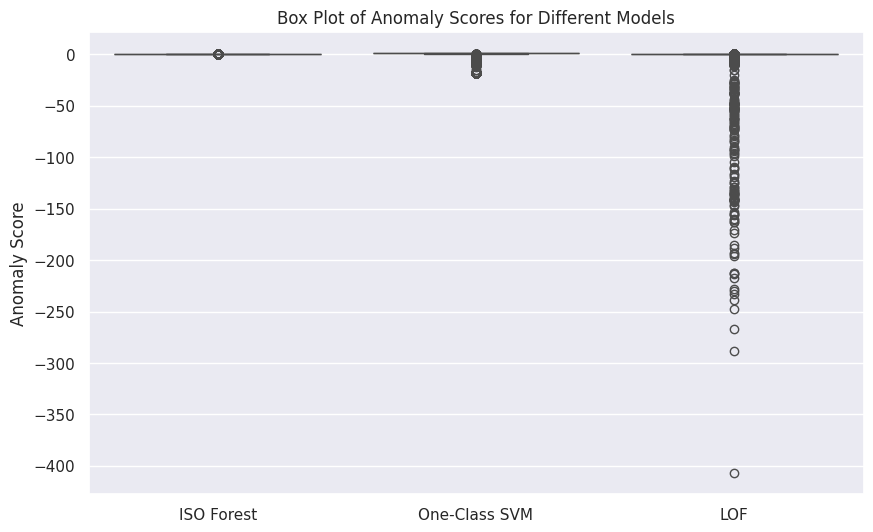

In [123]:
comparison_df = pd.DataFrame({
    'ISO Forest': iso_forest_results['Score'],
    'One-Class SVM': ocsvm_results['Score'],
    'LOF': lof_results['Score']
})

plt.figure(figsize=(10, 6))
sns.boxplot(data=comparison_df)
plt.title('Box Plot of Anomaly Scores for Different Models')
plt.ylabel('Anomaly Score')
plt.show()

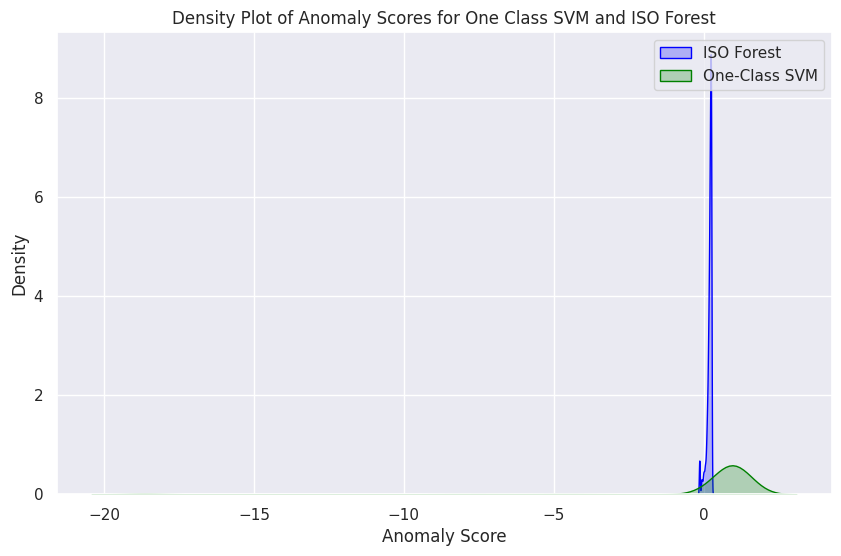

In [124]:
plt.figure(figsize=(10, 6))
sns.kdeplot(iso_forest_results['Score'], label='ISO Forest', color='blue', shade=True)
sns.kdeplot(ocsvm_results['Score'], label='One-Class SVM', color='green', shade=True)
plt.title('Density Plot of Anomaly Scores for One Class SVM and ISO Forest')
plt.xlabel('Anomaly Score')
plt.ylabel('Density')
plt.legend()
plt.show()

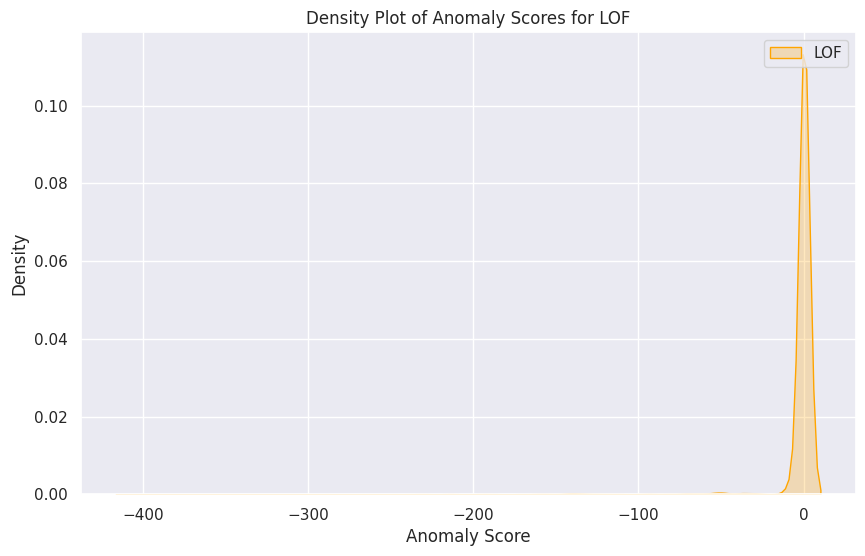

In [125]:
plt.figure(figsize=(10, 6))
sns.kdeplot(lof_results['Score'], label='LOF', color='orange', shade=True)
plt.title('Density Plot of Anomaly Scores for LOF')
plt.xlabel('Anomaly Score')
plt.ylabel('Density')
plt.legend()
plt.show()